# Total Energy Forecasting (28 Days with "Running")

### Libraries & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, Model, Input

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 2000)


### Data Loading & Preparation

74 columns dropped.
34 columns dropped: [' [TPE_0006.BarrelZone01_Act]', ' [TPE_0006.BarrelZone01_Set]', ' [TPE_0006.BarrelZone15_Act]', ' [TPE_0006.BarrelZone15_Set]', ' [TPE_0006.CoolingWater]', ' [TPE_0006.DosingUnit09_Act]', ' [TPE_0006.DosingUnit09_ActPercent]', ' [TPE_0006.DosingUnit09_FeederSpeed]', ' [TPE_0006.DosingUnit09_Set]', ' [TPE_0006.DosingUnit09_SetPercent]', ' [TPE_0006.DosingUnit10_Act]', ' [TPE_0006.DosingUnit10_ActPercent]', ' [TPE_0006.DosingUnit10_FeederSpeed]', ' [TPE_0006.DosingUnit10_Set]', ' [TPE_0006.DosingUnit10_SetPercent]', ' [TPE_0006.DosingUnitTotalizer10]', ' [TPE_0006.DosingUnitTotalizer9]', ' [TPE_0006.Filter]', ' [TPE_0006.Item_request_For_QualitySilo]', ' [TPE_0006.Item_response_For_QualitySilo]', ' [TPE_0006.MeltTemp01_Act]', ' [TPE_0006.Oil1Percent]', ' [TPE_0006.Oil1Totalizer]', ' [TPE_0006.Oil2Percent]', ' [TPE_0006.Oil2Totalizer]', ' [TPE_0006.OilFirstEnj]', ' [TPE_0006.OilFourthEnj]', ' [TPE_0006.OilSecondEnj]', ' [TPE_0006.OilThirdEnj]', ' [

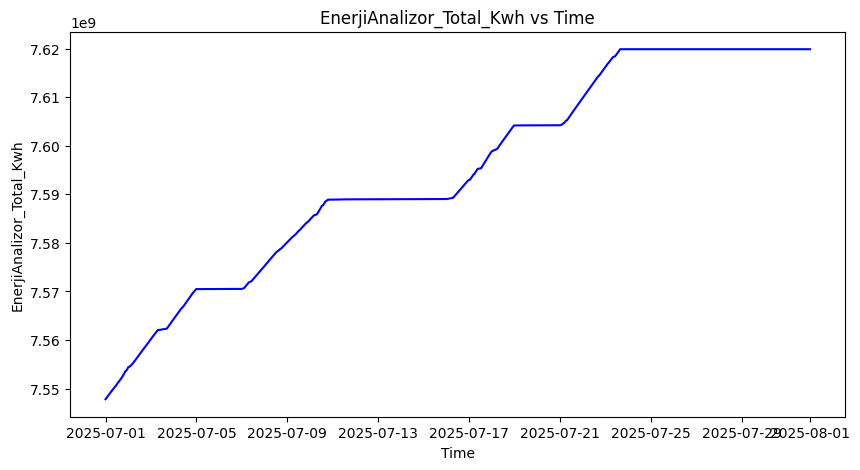

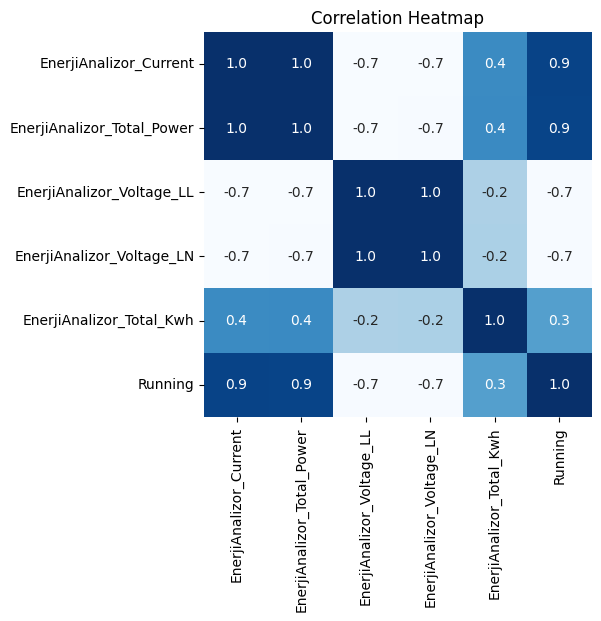

In [ ]:
# Data Loading
df = pd.read_csv("../data/tpe6_july_2025.csv")

# Convert DateTime column to datetime type and set as index
df["DateTime"] = pd.to_datetime(df["DateTime"], format="%m/%d/%y %H:%M")
df = df.set_index("DateTime")

# Drop columns with all missing values
missing_counts = df.isnull().sum()
cols_to_drop = missing_counts[missing_counts == 44640].index
df = df.drop(columns=cols_to_drop)
print(f"{len(cols_to_drop)} columns dropped.")

# Drop columns with a single unique value
unique_counts = df.nunique()
cols_to_drop = unique_counts[unique_counts == 1].index
df = df.drop(columns=cols_to_drop)
print(f"{len(cols_to_drop)} columns dropped: {list(cols_to_drop)}")

# Remove square brackets from column names
df.columns = df.columns.str.strip().str.replace("[", "").str.replace("]", "")

# Remove TPE 0006
df.columns = df.columns.str.replace(r"_TPE_\d+\.", "_", regex=True)
df.columns = df.columns.str.replace(r"TPE_\d+\.", "", regex=True)

df = df[[
    "EnerjiAnalizor_Current",
    "EnerjiAnalizor_Total_Power",
    "EnerjiAnalizor_Voltage_LL",
    "EnerjiAnalizor_Voltage_LN",
    "EnerjiAnalizor_Total_Kwh",
    "Running"
]]

# Fill missing values in the "Running" column
df["Running"] = df["Running"].fillna(method="bfill").astype(int)

print(df.head())

# Plot EnerjiAnalizor_Total_Kwh vs Time
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["EnerjiAnalizor_Total_Kwh"], color="blue")
plt.title("EnerjiAnalizor_Total_Kwh vs Time")
plt.xlabel("Time")
plt.ylabel("EnerjiAnalizor_Total_Kwh")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(df.corr(), annot=True, cbar=False, cmap='Blues', fmt='.1f')
plt.title("Correlation Heatmap")
plt.show()


### Data Preprocessing

In [3]:
# Convert minute data to hourly
agg = {
    "EnerjiAnalizor_Current": "mean",
    "EnerjiAnalizor_Total_Power": "mean",
    "EnerjiAnalizor_Voltage_LL": "mean",
    "EnerjiAnalizor_Voltage_LN": "mean",
    "EnerjiAnalizor_Total_Kwh": "last",  # or 'max'
    "Running": lambda s: int(s.mean()>=0.5),  # or 'min' / 'max'
}

df = df.resample("H").agg(agg).ffill()
df["Running"] = df["Running"].astype(int)


In [4]:
# Instead of cumulative Kwh data, use Kwh difference data (hourly consumption)
df["EnerjiAnalizor_Kwh_Diff"] = df["EnerjiAnalizor_Total_Kwh"].diff().clip(lower=0).fillna(0)

# Reset Kwh difference data to zero when Running=0 (guarantee)
# df.loc[df["Running"] == 0, "EnerjiAnalizor_Kwh_Diff"] = 0


In [5]:
# Target and features
target_diff = "EnerjiAnalizor_Kwh_Diff"
target_run  = "Running"
features = [c for c in df.columns if c not in ["EnerjiAnalizor_Total_Kwh", target_diff, target_run]]

X_raw   = df[features].values
y_diff  = df[[target_diff]].values
y_run   = df[[target_run]].values  # 0/1

# Scale
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_diff_sc = scaler_y.fit_transform(y_diff)
y_run_bin = y_run.astype(float)


In [6]:
# Create sequences
SEQ_LEN = 168    # past 168 hours (1 week)
HORIZON = 504   # future 504 hours (4 weeks)

def create_sequences_multitask(X, y_diff, y_run, seq_len, horizon):
    Xs, Ydiff, Yrun = [], [], []
    for i in range(len(X) - seq_len - horizon):
        Xs.append(X[i:i+seq_len])
        Ydiff.append(y_diff[i+seq_len:i+seq_len+horizon].reshape(-1))
        Yrun.append(y_run[i+seq_len:i+seq_len+horizon].reshape(-1))
    return np.array(Xs), np.array(Ydiff), np.array(Yrun)

X_seq, Ydiff_seq, Yrun_seq = create_sequences_multitask(X_scaled, y_diff_sc, y_run_bin, SEQ_LEN, HORIZON)


In [7]:
# Train/Test split
split = int(len(X_seq) * 0.8)
X_train, X_test     = X_seq[:split],     X_seq[split:]
Ydiff_train, Ydiff_test = Ydiff_seq[:split], Ydiff_seq[split:]
Yrun_train,  Yrun_test  = Yrun_seq[:split],  Yrun_seq[split:]


### Model Training

In [ ]:
inp = Input(shape=(SEQ_LEN, X_train.shape[2]))
x = layers.LSTM(64, return_sequences=True, activation="tanh", kernel_regularizer=l2(1e-4))(inp)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(32, return_sequences=False, activation="tanh", kernel_regularizer=l2(1e-4))(x)
x = layers.Dropout(0.2)(x)

# Diff head (non-negative)
diff_head = layers.Dense(HORIZON, activation="relu", name="diff_head")(x)
# Running head (probabilities)
run_head  = layers.Dense(HORIZON, activation="sigmoid", name="run_head")(x)

model = Model(inputs=inp, outputs=[diff_head, run_head])

# --- Special loss: diff MSE * real running mask ---
def masked_mse(y_true, y_pred):
    # y_true: real diff (scaled)
    # y_pred: predicted diff (scaled)
    return tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)

bce = tf.keras.losses.BinaryCrossentropy()

'''
To include the mask in the loss in Keras, we could provide y_true as (diff, mask):
Instead, a simpler way: multiply the diff_loss by the mask during training (no need for a custom train_step)
Practical solution: already provide Ydiff multiplied by "real running" as the target:
-> This way, the model is forced to produce large values for diff_head only when running=1.
'''

model.compile(optimizer="adam",
              loss={"diff_head": masked_mse, "run_head": bce},
              loss_weights={"diff_head": 1.0, "run_head": 1.0})

es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
history = model.fit(
    X_train,
    {"diff_head": Ydiff_train * Yrun_train, "run_head": Yrun_train},  # diff için maskeli hedef
    validation_data=(X_test, {"diff_head": Ydiff_test * Yrun_test, "run_head": Yrun_test}),
    epochs=80,
    batch_size=16,
    callbacks=[es],
    verbose=1
)

# Model Save
# model.save("../models/forecast_28days_lstm_model.keras")

Epoch 1/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - diff_head_loss: 0.1254 - loss: 0.8269 - run_head_loss: 0.6912 - val_diff_head_loss: 0.1019 - val_loss: 0.7979 - val_run_head_loss: 0.6871
Epoch 2/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - diff_head_loss: 0.1154 - loss: 0.8051 - run_head_loss: 0.6795 - val_diff_head_loss: 0.0951 - val_loss: 0.7770 - val_run_head_loss: 0.6732
Epoch 3/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - diff_head_loss: 0.1017 - loss: 0.7660 - run_head_loss: 0.6538 - val_diff_head_loss: 0.0957 - val_loss: 0.7562 - val_run_head_loss: 0.6519
Epoch 4/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - diff_head_loss: 0.0904 - loss: 0.7214 - run_head_loss: 0.6205 - val_diff_head_loss: 0.1033 - val_loss: 0.7420 - val_run_head_loss: 0.6302
Epoch 5/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - diff_head_loss: 0.0847 - loss: 0.6793 - run_head_loss: 0.5860 - val_diff_head_loss: 0.1124 - val_loss: 0.7295 - val_run_head_loss: 0.6086
Epoch 6/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - dif

### Forecasting

In [9]:
# Last window
last_X = X_scaled[-SEQ_LEN:][None, ...]

pred_diff_sc, pred_run_prob = model.predict(last_X)

pred_run_prob = pred_run_prob.reshape(-1)     # (72,)
pred_diff_sc  = pred_diff_sc.reshape(-1)      # (72,)

# Threshold: 0.5
RUN_THRESH = 0.5
pred_run_bin = (pred_run_prob >= RUN_THRESH).astype(int)

# Inverse scale the diff
pred_diff = scaler_y.inverse_transform(pred_diff_sc.reshape(-1,1)).reshape(-1)

# Rule: if Running=0, diff=0
pred_diff = pred_diff * pred_run_bin

# Convert to cumulative
last_cum = df["EnerjiAnalizor_Total_Kwh"].iloc[-1]
pred_cum = last_cum + np.cumsum(pred_diff)

# Time index
last_date = df.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(hours=1), periods=HORIZON, freq="H")

forecast = pd.DataFrame({
    "Pred_Run_Prob": pred_run_prob,
    "Pred_Run": pred_run_bin,
    "Pred_Kwh_Diff": pred_diff,
    "Pred_Kwh_Cum": pred_cum
}, index=future_dates)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


### Visualization

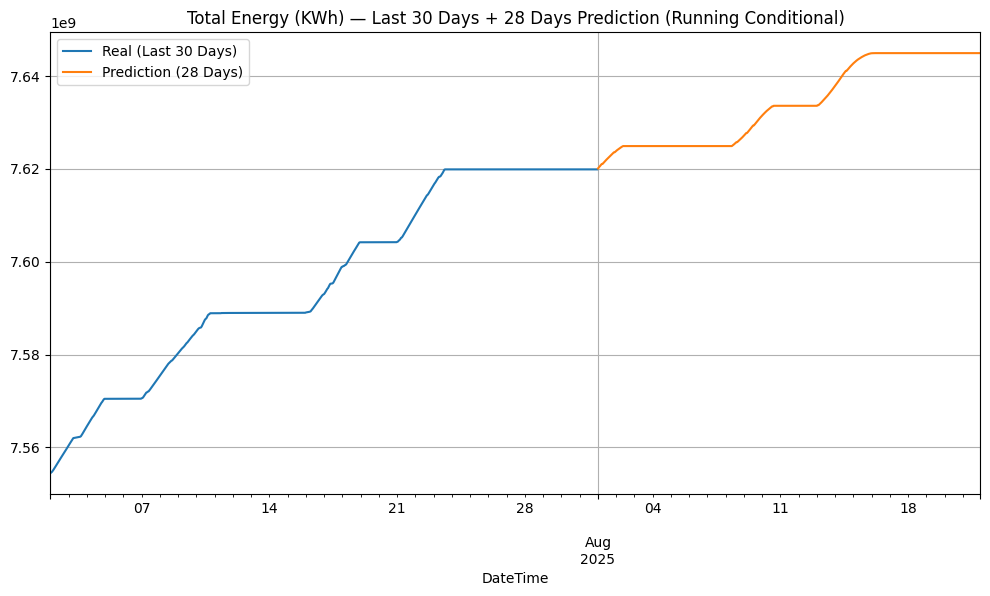

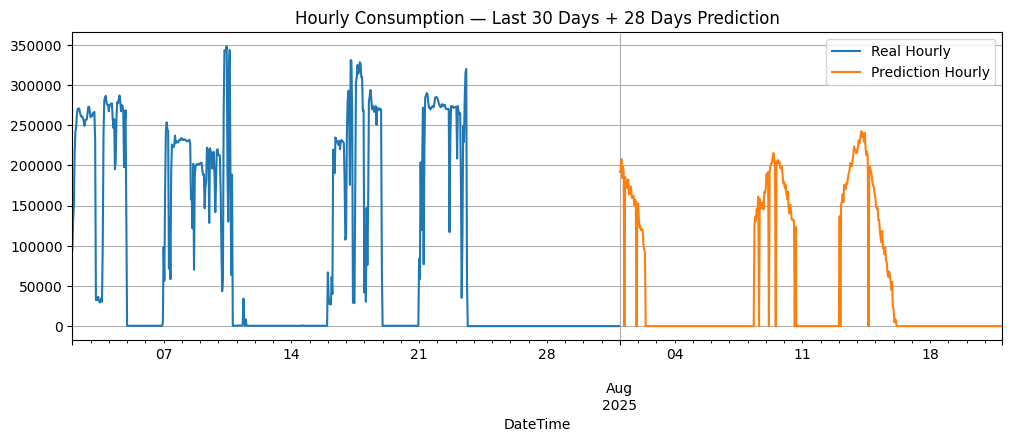

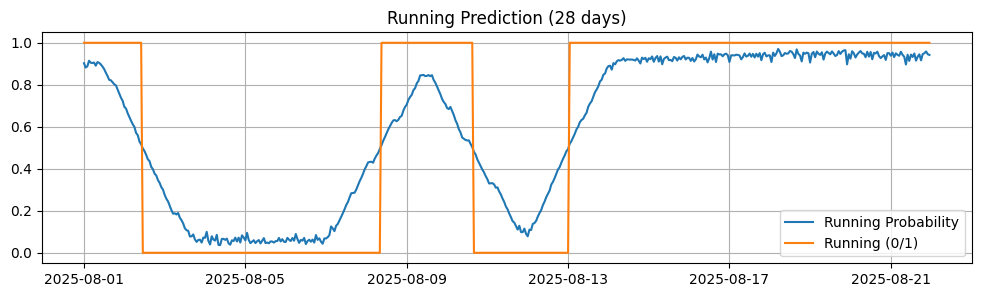

In [10]:
# Cumulative total energy prediction
plt.figure(figsize=(12,6))
df["EnerjiAnalizor_Total_Kwh"].last("30D").plot(label="Real (Last 30 Days)")
forecast["Pred_Kwh_Cum"].plot(label="Prediction (28 Days)")
plt.title("Total Energy (KWh) — Last 30 Days + 28 Days Prediction (Running Conditional)")
plt.legend(); plt.grid(True); plt.show()

# Hourly diff
plt.figure(figsize=(12,4))
df["EnerjiAnalizor_Kwh_Diff"].last("30D").plot(label="Real Hourly")
forecast["Pred_Kwh_Diff"].plot(label="Prediction Hourly")
plt.title("Hourly Consumption — Last 30 Days + 28 Days Prediction")
plt.legend(); plt.grid(True); plt.show()

# Running probability
plt.figure(figsize=(12,3))
plt.plot(forecast.index, forecast["Pred_Run_Prob"], label="Running Probability")
plt.plot(forecast.index, forecast["Pred_Run"], label="Running (0/1)")
plt.ylim(-0.05, 1.05); plt.title("Running Prediction (28 days)")
plt.legend(); plt.grid(True); plt.show()
